# Thesis Chapter 6.1: Climate indicators

In [1]:
import os
import sys
import numpy as np
import xarray as xr
import cmocean
import cartopy
import scipy.stats as stats
import cartopy.crs as ccrs
import datetime
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
matplotlib.rc_file('../rc_file')
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("..")
from tqdm import notebook
from paths import path_results, path_prace, CESM_filename, file_ex_atm_lpd
from filters import lowpass
from constants import spy
from xr_regression import xr_linear_trend, xr_lintrend
from constants import R_earth
A_Earth = 4*np.pi*R_earth**2

The file "/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f09_g16/spinup_pd_maxcores_f09_g16/run/spinup_pd_maxcores_f09_g16.cam2.h0.0001-01.nc" does not exist


In [4]:
GMST_ctrl  = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_ctrl.nc', decode_times=False)
GMST_lpd  = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_lpd.nc' , decode_times=False)

GMST_h200  = GMST_ctrl.sel(time=slice(200*365,230*365)).mean()
GMST_l500  = GMST_lpd.isel(time=slice(0,30*12)).mean()
GMST_l1200 = GMST_lpd.isel(time=slice(690*12,720*12)).mean()

In [25]:
GMST_lpd.isel(time=slice(12*700,None))

<xarray.DataArray (time: 252)>
array([286.529569, 286.86059 , 287.449418, ..., 288.847321, 287.691582,
       286.850743])
Coordinates:
    lev      float64 992.6
  * time     (time) float64 4.377e+05 4.377e+05 ... 4.453e+05 4.453e+05

In [26]:
252/12

21.0

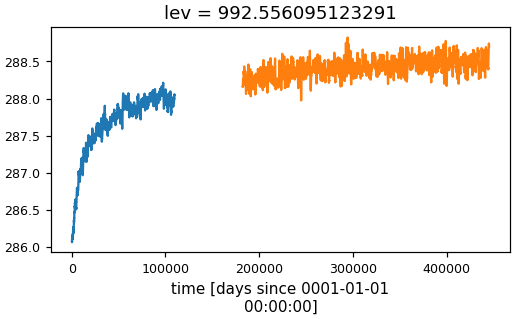

In [7]:
GMST_ctrl.rolling(time=12).mean().plot()
GMST_lpd.rolling(time=12).mean().plot()

In [9]:
S_Earth = (4*np.pi*R_earth**2)

In [10]:
TOAx4 = xr.open_dataarray('../../data/CMIP5/netTOA_CESM104_abrupt4x_5900.nc')
mocx4 = xr.open_dataarray('../../data/CMIP5/AMOC_ann_CESM104_abrupt4x_5900.nc', decode_times=False)
co2x4 = xr.open_dataarray('../../data/CMIP5/tas_CESM104_abrupt4x_5900.nc')
cmipc = xr.open_dataarray('../../data/CMIP5/tas_CESM104_control_1000.nc')
co2x4 -= cmipc.mean()

In [69]:
print(f'{co2x4.isel(year=50).values:.3f}, {co2x4.isel(year=50).values/6.73*100:.0f} %')
print(f'{co2x4.isel(year=slice(40,50)).mean().values:.3f} +/- {co2x4.isel(year=slice(40,50)).std().values:.2f}, {co2x4.isel(year=slice(40,50)).mean().values/6.73*100:.0f} %')

3.961, 59 %
3.833 +/- 0.10, 57 %


In [89]:
# 
for i, run in enumerate(['rcp', 'lr1', 'hq', 'lq']):
    gmst_offset = [GMST_h200, GMST_l500, GMST_h200, GMST_l1200][i]
    go = [200, 0, 200, 700][i]
    t  = [90,90,40,40][i]
    ctl  = ['ctrl','lpd','ctrl','lpd'][i]
    GMST = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_{run}.nc', decode_times=False).isel(time=slice(12*t,12*(t+10)))
    ctl_ = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_{ctl}.nc', decode_times=False).isel(time=slice(12*(go+t),12*(go+t+10)))
    if i==3:
        ctl_ = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_{ctl}.nc', decode_times=False).isel(time=slice(12*go,12*(go+10)))
        
    print(f'{run:4}: {(GMST.mean()-gmst_offset).values:.3f} +/- {float(GMST.rolling(time=12).mean().std().values):.3f} K')
    print(f'{run:4}: {(GMST.mean()-ctl_.mean()).values:.3f} +/- {float(GMST.rolling(time=12).mean().std().values):.3f} K')
    

rcp : 2.953 +/- 0.114 K
rcp : 2.962 +/- 0.114 K
lr1 : 2.757 +/- 0.118 K
lr1 : 2.720 +/- 0.118 K
hq  : 4.659 +/- 0.093 K
hq  : 4.610 +/- 0.093 K
lq  : 4.738 +/- 0.098 K
lq  : 4.772 +/- 0.098 K


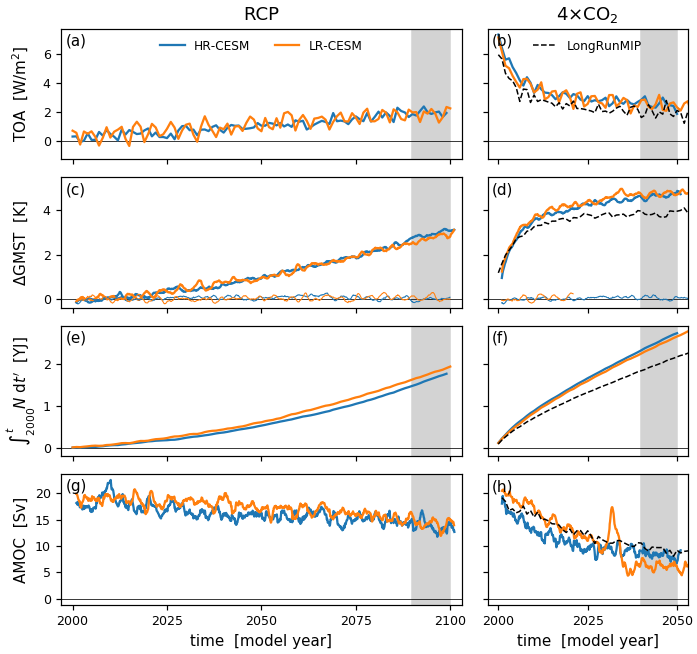

In [31]:
f, ax = plt.subplots(4,2, figsize=(6.4,6), sharex='col', sharey='row', gridspec_kw={'width_ratios':[2,1]}, constrained_layout=True)
letters = 'abcdefgh'
ylabels = [r'TOA  [W/m$^2$]', r'$\Delta$GMST  [K]', r'$\int_{2000}^t N$ d$t^\prime$  [YJ]', 'AMOC  [Sv]']

ax[0,0].set_title('RCP')
ax[0,1].set_title(r'4$\times$CO$_2$')

for i in range(4):
    ax[i,0].text(-.1, .5, ylabels[i], rotation=90, va='center', ha='center', transform=ax[i,0].transAxes)
    for j in range(2):
        ax[i,j].axvspan([2090,2040][j], [2100,2050][j], color='lightgrey')
        ax[i,j].axhline(0, c='k', lw=.5)

for i, run in enumerate(['rcp', 'lr1', 'hq', 'lq']):
    ye = [2100, 2101, 2051, 2091][i]
    j = int(i/2)
    c = f'C{int(i%2)}'
    gmst_offset = [GMST_h200, GMST_l500, GMST_h200, GMST_l1200][i]
    TOA = xr.open_dataarray(f'{path_prace}/TOA/TOM_{run}.nc', decode_times=False)
    GMST = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_{run}.nc', decode_times=False)
    AMOC = xr.open_dataarray(f'{path_results}/MOC/AMOC_max_{run}.nc', decode_times=False)

    ax[0,j].plot(np.arange(2000,ye), TOA/S_Earth, label=['HR-CESM','LR-CESM','',''][i])
    if j==0:  ax[0,0].legend(fontsize=8, ncol=2, loc='upper center', frameon=False)
    ax[1,j].plot(GMST.time/365+2000, GMST.rolling(time=12).mean()-gmst_offset )
    ax[2,j].plot(np.arange(2000,ye), TOA.cumsum('time')*spy/1e24)
    ax[2,j].set_ylim(-.2,2.9)
    ax[3,j].plot(AMOC.time/365, AMOC.rolling(time=12).mean())

for i in range(2):
    ax[1,i].plot(np.arange(2000,2100,1/12), GMST_ctrl.isel(time=slice(12*200,12*300)).rolling(time=12).mean()-GMST_h200, c='C0', lw=.7)
ax[1,0].plot(np.arange(2000,2100,1/12), GMST_lpd.isel(time=slice(0,12*100)).rolling(time=12).mean()-GMST_l500, c='C1', lw=.7)
ax[1,1].plot(np.arange(2000,2021,1/12), GMST_lpd.isel(time=slice(12*700,12*721)).rolling(time=12).mean()-GMST_l1200, c='C1', lw=.7)

for i in range(4):
    for j in range(2):
        ax[i,j].text(.01*(j+1),.87, '('+letters[2*i+j]+')', transform=ax[i,j].transAxes)

# for i, run in enumerate(['ctrl', 'lc1']):
ax[0,1].plot(TOAx4.year+2000, TOAx4, c='k', ls='--', lw=1, label='LongRunMIP')
ax[0,1].legend(fontsize=8, loc='upper center', frameon=False)
ax[1,1].plot(co2x4.year+2000, co2x4, c='k', ls='--', lw=1)
ax[2,1].plot(TOAx4.year+2000, TOAx4.cumsum('year')*S_Earth*spy/1e24, c='k', ls='--', lw=1)
ax[3,1].plot(mocx4.time+2000, mocx4, c='k', ls='--', lw=1)

for i in range(2):
    ax[3,i].set_xticks(np.arange(2000,2101,25))
    ax[3,i].set_xlim([(1997,2103),(1997,2053)][i])
    ax[3,i].set_xlabel('time  [model year]')

ax[1,0].set_ylim((-.4,5.5))
f.align_ylabels()

# plt.savefig(f'{path_results}/thesis/61_climate_response')
plt.savefig(f'{path_results}/thesis/61_climate_response.eps')

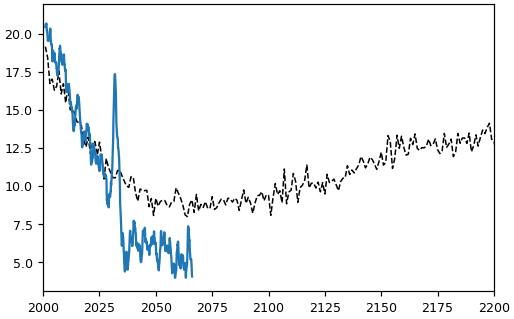

In [23]:
plt.plot(mocx4.time+2000, mocx4, c='k', ls='--', lw=1)
plt.xlim((2000,2200))
AMOC_lq = xr.open_dataarray(f'{path_results}/MOC/AMOC_max_lq.nc', decode_times=False)
plt.plot(AMOC_lq.time/365, AMOC_lq.rolling(time=12).mean())

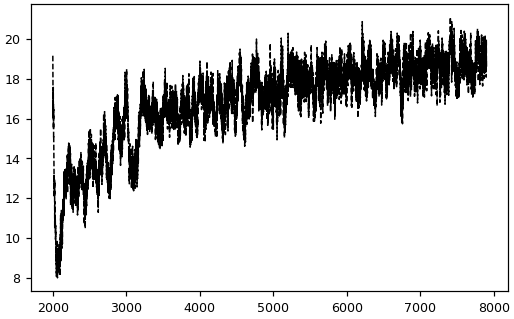

In [24]:
plt.plot(mocx4.time+2000, mocx4, c='k', ls='--', lw=1)

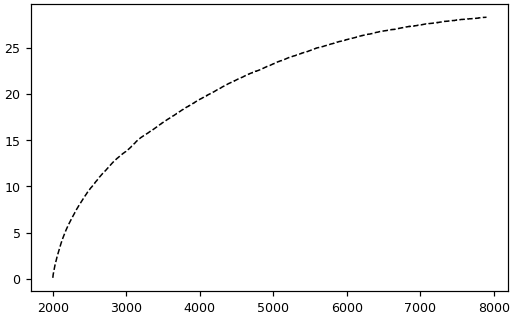

In [18]:
plt.plot(mocx4.time+2000, TOAx4.cumsum('year')*S_Earth*spy/1e24, c='k', ls='--', lw=1)